# Invariant Δv Planning with Log-Linear SE₂(3) Dynamics

This notebook demonstrates the invariant Δv planning method from the log-linear SE₂(3) formulation.

**Key features:**
- Uses invariant error dynamics from the paper: ξ̇ = Aξ
- Retains first-order differential gravity (gravity gradient)
- Accounts for attitude-translation coupling during thrust
- Compares with HCW by transforming HCW results to invariant coordinates

## Coordinate Transformation

The relationship between invariant and LVLH velocities (Eq. 17 of the paper):
$$v_{\text{LVLH}} = \xi_v - \Omega \times \xi_p$$

For impulsive maneuvers (position unchanged): $\Delta v_{\text{LVLH}} = \Delta \xi_v$

The key difference is in how the dynamics propagate the state, not in the impulse magnitudes.

## Organization

**Tier 1: HCW Special Case (Sanity Checks)**
1. Coasting circular rendezvous - compare with HCW
2. Δv vs transfer time sweep
3. Out-of-plane (3D) case

**Tier 2: Beyond HCW (The Contribution)**
4. Thrusting reference trajectory
5. Attitude-translation coupling
6. LVLH vs body-frame Δv
7. Non-circular/time-varying reference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import solve_ivp
import sys
from pathlib import Path

# Add repo root to path
repo_root = None
for path in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
    if (path / "cp_reach").exists():
        repo_root = path
        break
if repo_root is None:
    raise RuntimeError("Could not locate repo root")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from cp_reach.applications.satellite.transfer_dynamics import (
    hcw_state_matrix,
    hcw_state_transition_matrix,
    hcw_transfer_velocity,
    hcw_simulate_transfer,
    circular_orbit_gravity_gradient,
    orbital_params_from_radius
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

In [2]:
%load_ext autoreload
%autoreload 2

## Core Functions: Invariant Δv Planning

The A matrix for log-linear error dynamics on SE₂(3):
$$\dot{\xi} = A \xi$$

where $A = -\text{ad}_{\bar{n}} + A_C + A_G$:
- $-\text{ad}_{\bar{n}}$: adjoint action of reference motion
- $A_C$: kinematic coupling (I in position-velocity block)  
- $A_G$: gravity gradient contribution (adds G to velocity-position block)

For circular orbit coasting ($\bar{a}=0$), the structure is:
$$A = \begin{bmatrix} -[\bar{\omega}]_\times & I & 0 \\ G & -[\bar{\omega}]_\times & 0 \\ 0 & 0 & -[\bar{\omega}]_\times \end{bmatrix}$$

**Note:** The current `log_linear_dynamics.py` doesn't include gravity gradient by default. We add it here for HCW comparison.

In [3]:
def skew(v):
    """Skew-symmetric matrix [v]_x such that [v]_x @ w = v x w."""
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])


def invariant_A_matrix(omega_bar, a_bar, G):
    """
    Build the 9x9 A matrix for invariant log-linear error dynamics.
    
    From Eq. (7) of the paper:
        A = [[-[ω̄]×,  I,      0     ],
             [G,      -[ω̄]×,  -[ā]× ],
             [0,       0,     -[ω̄]× ]]
    
    This is the INVARIANT formulation - NOT HCW.
    
    Parameters
    ----------
    omega_bar : ndarray (3,)
        Reference angular velocity (rad/s)
    a_bar : ndarray (3,)
        Reference body-frame acceleration (m/s²)
    G : ndarray (3, 3)
        Gravity gradient tensor
    
    Returns
    -------
    A : ndarray (9, 9)
    """
    omega_skew = skew(omega_bar)
    a_skew = skew(a_bar)
    I3 = np.eye(3)
    Z3 = np.zeros((3, 3))
    
    A = np.block([
        [-omega_skew, I3,          Z3         ],
        [G,           -omega_skew, -a_skew    ],
        [Z3,          Z3,          -omega_skew]
    ])
    return A


def hcw_A_matrix_6x6(n):
    """
    Build 6x6 HCW A matrix in LVLH coordinates.
    
    The HCW equations in LVLH frame:
        ẍ - 3n²x - 2nẏ = 0
        ÿ + 2nẋ = 0
        z̈ + n²z = 0
    
    State: [r, v] in LVLH (6-dimensional)
    """
    A = np.zeros((6, 6))
    A[0:3, 3:6] = np.eye(3)  # ṙ = v
    A[3, 0] = 3*n**2         # gravity gradient x
    A[5, 2] = -n**2          # gravity gradient z  
    A[3, 4] = 2*n            # Coriolis
    A[4, 3] = -2*n           # Coriolis
    return A


def compute_stm(A_func, T, n_steps=1000):
    """
    Compute state transition matrix by integrating Φ̇ = A(t)Φ.
    
    For LTI systems, this is just expm(A*T).
    For LTV systems, we integrate numerically.
    """
    if not callable(A_func):
        return expm(A_func * T)
    
    # LTV case: numerical integration
    n = A_func(0).shape[0]
    def phi_dot(t, phi_flat):
        Phi = phi_flat.reshape(n, n)
        A = A_func(t)
        return (A @ Phi).flatten()
    
    Phi0 = np.eye(n).flatten()
    sol = solve_ivp(phi_dot, [0, T], Phi0, dense_output=True, rtol=1e-10, atol=1e-12)
    return sol.y[:, -1].reshape(n, n)


def stm_blocks(Phi):
    """Partition 9x9 STM into 3x3 blocks."""
    return {
        'pp': Phi[0:3, 0:3], 'pv': Phi[0:3, 3:6], 'pR': Phi[0:3, 6:9],
        'vp': Phi[3:6, 0:3], 'vv': Phi[3:6, 3:6], 'vR': Phi[3:6, 6:9],
        'Rp': Phi[6:9, 0:3], 'Rv': Phi[6:9, 3:6], 'RR': Phi[6:9, 6:9],
    }


def two_impulse_transfer(xi_0, Phi, R_ref_0=None, R_ref_T=None):
    """
    Compute two-impulse transfer using STM.
    
    Enforces ξ_p(T) = 0 (terminal position targeting).
    """
    if R_ref_0 is None:
        R_ref_0 = np.eye(3)
    if R_ref_T is None:
        R_ref_T = np.eye(3)
    
    xi_p_0 = xi_0[0:3]
    xi_v_0 = xi_0[3:6]
    xi_R_0 = xi_0[6:9]
    
    blocks = stm_blocks(Phi)
    Phi_pp = blocks['pp']
    Phi_pv = blocks['pv']
    Phi_pR = blocks['pR']
    
    # Departure impulse: Δv(0) = -Φ_pv^{-1} (Φ_pp ξ_p(0) + Φ_pR ξ_R(0) + Φ_pv ξ_v(0))
    term_pp = Phi_pp @ xi_p_0
    term_pR = Phi_pR @ xi_R_0
    term_pv = Phi_pv @ xi_v_0
    rhs = term_pp + term_pR + term_pv
    delta_v_0 = -np.linalg.solve(Phi_pv, rhs)
    
    # Post-burn initial condition
    xi_0_plus = xi_0.copy()
    xi_0_plus[3:6] = xi_v_0 + delta_v_0
    
    # Propagate to terminal time
    xi_T_minus = Phi @ xi_0_plus
    xi_v_T_minus = xi_T_minus[3:6]
    
    # Arrival impulse (brake to zero velocity)
    delta_v_T = -xi_v_T_minus
    
    # Map to body frame if needed
    delta_v_0_body = R_ref_0 @ delta_v_0
    delta_v_T_body = R_ref_T @ delta_v_T
    
    # Total cost
    delta_v_total = np.linalg.norm(delta_v_0) + np.linalg.norm(delta_v_T)
    
    return {
        'delta_v_0': delta_v_0,
        'delta_v_T': delta_v_T,
        'delta_v_0_body': delta_v_0_body,
        'delta_v_T_body': delta_v_T_body,
        'delta_v_0_norm': np.linalg.norm(delta_v_0),
        'delta_v_T_norm': np.linalg.norm(delta_v_T),
        'delta_v_total': delta_v_total,
        'xi_0_plus': xi_0_plus,
        'xi_T_minus': xi_T_minus,
        'Phi': Phi,
        'blocks': blocks,
        'term_pp': term_pp,
        'term_pR': term_pR,
        'term_pv': term_pv,
    }


def hcw_two_impulse(r_0, v_0, Phi_hcw):
    """
    Compute two-impulse transfer using HCW STM (6x6).
    
    State: [r, v] in LVLH (6-dimensional)
    """
    Phi_rr = Phi_hcw[0:3, 0:3]
    Phi_rv = Phi_hcw[0:3, 3:6]
    
    # Departure impulse to reach origin at T
    delta_v_0 = -np.linalg.solve(Phi_rv, Phi_rr @ r_0 + Phi_rv @ v_0)
    
    # Post-burn state
    state_0_plus = np.concatenate([r_0, v_0 + delta_v_0])
    state_T = Phi_hcw @ state_0_plus
    
    # Arrival impulse
    delta_v_T = -state_T[3:6]
    
    return {
        'delta_v_0': delta_v_0,
        'delta_v_T': delta_v_T,
        'delta_v_0_norm': np.linalg.norm(delta_v_0),
        'delta_v_T_norm': np.linalg.norm(delta_v_T),
        'delta_v_total': np.linalg.norm(delta_v_0) + np.linalg.norm(delta_v_T),
        'state_0_plus': state_0_plus,
        'state_T': state_T,
    }

In [4]:
def propagate_trajectory(xi_0, A_func, t_span, rtol=1e-10, atol=1e-12):
    """
    Propagate dynamics ξ̇ = A(t)ξ.
    
    Parameters
    ----------
    xi_0 : ndarray (9,)
        Initial state
    A_func : callable or ndarray
        A matrix (constant or time-varying)
    t_span : ndarray
        Time points to evaluate
    
    Returns
    -------
    xi_traj : ndarray (N, 9)
        State trajectory
    """
    if not callable(A_func):
        A_const = A_func
        A_func = lambda t: A_const
    
    def dynamics(t, xi):
        return A_func(t) @ xi
    
    sol = solve_ivp(dynamics, [t_span[0], t_span[-1]], xi_0,
                    t_eval=t_span, rtol=rtol, atol=atol)
    return sol.y.T

## Problem Setup

LEO circular orbit, typical rendezvous scenario.

In [5]:
# Orbital parameters
mu = 3.986e14  # Earth gravitational parameter (m³/s²)
r_orbit = 6.771e6  # Orbital radius (m) - ~400 km altitude

params = orbital_params_from_radius(r_orbit, mu)
n = params['n']  # Mean motion (rad/s)
T_orbit = params['T_orbit']  # Orbital period (s)

# IMPORTANT: The invariant formulation uses the TRUE gravity gradient (tidal tensor)
# NOT the HCW "effective" gravity which includes centrifugal.
#
# True tidal tensor: G_tidal = n² diag([2, -1, -1])
# HCW effective:     G_eff   = n² diag([3, 0, -1])  (includes centrifugal)
#
# The coordinate transformation v = ξ_v - Ω×ξ_p naturally introduces the 
# centrifugal term, so using G_tidal in invariant coordinates gives 
# G_eff in LVLH coordinates after transformation.
#
# Paper Eq. (3): G = (μ/||r||³)(3r̂r̂ᵀ - I) 
# For LVLH with r̂ = [1,0,0]: G = n² diag([2, -1, -1])

G_tidal = np.diag([2*n**2, -n**2, -n**2])  # True gravity gradient
G_eff = circular_orbit_gravity_gradient(n)  # HCW uses this (includes centrifugal)

# Use G_tidal for invariant formulation
G = G_tidal

# Reference angular velocity (circular orbit)
Omega = np.array([0.0, 0.0, n])

print(f"Orbital Parameters:")
print(f"  Radius: {r_orbit/1e6:.3f} km")
print(f"  Period: {T_orbit/60:.1f} min")
print(f"  Mean motion n: {n:.6e} rad/s")
print(f"\nGravity gradient tensors:")
print(f"  G_tidal (true, for invariant): diag([{G_tidal[0,0]/n**2:.0f}n², {G_tidal[1,1]/n**2:.0f}n², {G_tidal[2,2]/n**2:.0f}n²])")
print(f"  G_eff (HCW, includes centrifugal): diag([{G_eff[0,0]/n**2:.0f}n², {G_eff[1,1]/n**2:.0f}n², {G_eff[2,2]/n**2:.0f}n²])")
print(f"\nUsing G_tidal for invariant formulation.")

Orbital Parameters:
  Radius: 6.771 km
  Period: 92.4 min
  Mean motion n: 1.133155e-03 rad/s

Gravity gradient tensors:
  G_tidal (true, for invariant): diag([2n², -1n², -1n²])
  G_eff (HCW, includes centrifugal): diag([3n², 0n², -1n²])

Using G_tidal for invariant formulation.


---
# Tier 1: HCW Special Case (Sanity Checks)

## 1. Coasting Circular Rendezvous — Invariant vs HCW

For the comparison, we:
1. Compute the invariant solution using the paper's A matrix
2. Compute the HCW solution in LVLH coordinates
3. Transform HCW initial conditions to invariant coordinates for fair comparison

**Key insight:** For a chaser "at rest in LVLH" (v_LVLH = 0), the invariant velocity is:
$$\xi_v = v_{\text{LVLH}} + \Omega \times \xi_p = \Omega \times \xi_p \neq 0$$

In [6]:
# Rendezvous scenario in LVLH coordinates
# Chaser starts 100m radially above and 50m behind target
# Target at LVLH origin

r_0_lvlh = np.array([100.0, -50.0, 0.0])  # Position in LVLH (m)
v_0_lvlh = np.array([0.0, 0.0, 0.0])      # Velocity in LVLH (m/s) - at rest

# Transfer time: half orbit
T_transfer = 0.5 * T_orbit

# Transform to invariant coordinates
# ξ_p = r (position is the same)
# ξ_v = v_LVLH + Ω × ξ_p (velocity transformation)
xi_p_0 = r_0_lvlh
xi_v_0 = v_0_lvlh + np.cross(Omega, xi_p_0)  # Transform to invariant velocity
xi_R_0 = np.array([0.0, 0.0, 0.0])           # Attitude error

xi_0 = np.concatenate([xi_p_0, xi_v_0, xi_R_0])

print(f"Rendezvous Scenario:")
print(f"  Position (LVLH): r = {r_0_lvlh} m")
print(f"  Velocity (LVLH): v = {v_0_lvlh} m/s (at rest)")
print(f"  Transfer time: {T_transfer/60:.1f} min ({T_transfer/T_orbit:.2f} orbits)")
print(f"\nTransformed to invariant coordinates:")
print(f"  ξ_p = {xi_p_0} m")
print(f"  ξ_v = {xi_v_0} m/s  (= Ω × ξ_p since v_LVLH = 0)")
print(f"  ξ_R = {xi_R_0} rad")

Rendezvous Scenario:
  Position (LVLH): r = [100. -50.   0.] m
  Velocity (LVLH): v = [0. 0. 0.] m/s (at rest)
  Transfer time: 46.2 min (0.50 orbits)

Transformed to invariant coordinates:
  ξ_p = [100. -50.   0.] m
  ξ_v = [0.05665776 0.11331553 0.        ] m/s  (= Ω × ξ_p since v_LVLH = 0)
  ξ_R = [0. 0. 0.] rad


In [7]:
# Build both A matrices
a_bar_coast = np.array([0.0, 0.0, 0.0])  # No thrust (coasting)

# Invariant A matrix from the paper
A_inv = invariant_A_matrix(Omega, a_bar_coast, G)

# HCW A matrix (6x6 in LVLH)
A_hcw = hcw_A_matrix_6x6(n)

print("Invariant A matrix (9x9) - from paper Eq. (7):")
np.set_printoptions(precision=6, suppress=True, linewidth=120)
print(A_inv)

print("\n\nHCW A matrix (6x6) - LVLH coordinates:")
print(A_hcw)

Invariant A matrix (9x9) - from paper Eq. (7):
[[-0.        0.001133 -0.        1.        0.        0.        0.        0.        0.      ]
 [-0.001133 -0.        0.        0.        1.        0.        0.        0.        0.      ]
 [ 0.       -0.       -0.        0.        0.        1.        0.        0.        0.      ]
 [ 0.000003  0.        0.       -0.        0.001133 -0.       -0.        0.       -0.      ]
 [ 0.       -0.000001  0.       -0.001133 -0.        0.       -0.       -0.        0.      ]
 [ 0.        0.       -0.000001  0.       -0.       -0.        0.       -0.       -0.      ]
 [ 0.        0.        0.        0.        0.        0.       -0.        0.001133 -0.      ]
 [ 0.        0.        0.        0.        0.        0.       -0.001133 -0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.       -0.       -0.      ]]


HCW A matrix (6x6) - LVLH coordinates:
[[ 0.        0.        0.        1.        0.        0.      ]
 [ 0.      

In [8]:
# Compute STMs
Phi_inv = compute_stm(A_inv, T_transfer)  # 9x9 invariant
Phi_hcw = compute_stm(A_hcw, T_transfer)  # 6x6 HCW

# Solve using invariant method
result_inv = two_impulse_transfer(xi_0, Phi_inv)

# Solve using HCW method (in LVLH coordinates)
result_hcw = hcw_two_impulse(r_0_lvlh, v_0_lvlh, Phi_hcw)

# Key relationship: For impulsive burns, Δv_LVLH = Δξ_v
# Since position doesn't jump: v(0+) - v(0-) = ξ_v(0+) - ξ_v(0-)

print("=" * 70)
print("COMPARISON: Invariant Method vs HCW")
print("=" * 70)

print(f"\nInvariant Method (using paper's A matrix):")
print(f"  Δξ_v(0) = [{result_inv['delta_v_0'][0]:.6f}, {result_inv['delta_v_0'][1]:.6f}, {result_inv['delta_v_0'][2]:.6f}] m/s")
print(f"  ||Δξ_v(0)|| = {result_inv['delta_v_0_norm']:.6f} m/s")
print(f"  ||Δξ_v(T)|| = {result_inv['delta_v_T_norm']:.6f} m/s")
print(f"  Total = {result_inv['delta_v_total']:.6f} m/s")

print(f"\nHCW Method (LVLH coordinates):")
print(f"  Δv_L(0) = [{result_hcw['delta_v_0'][0]:.6f}, {result_hcw['delta_v_0'][1]:.6f}, {result_hcw['delta_v_0'][2]:.6f}] m/s")
print(f"  ||Δv_L(0)|| = {result_hcw['delta_v_0_norm']:.6f} m/s")
print(f"  ||Δv_L(T)|| = {result_hcw['delta_v_T_norm']:.6f} m/s")
print(f"  Total = {result_hcw['delta_v_total']:.6f} m/s")

print(f"\n--- Comparison (should match for Tier-1) ---")
dv0_diff = abs(result_inv['delta_v_0_norm'] - result_hcw['delta_v_0_norm'])
dvT_diff = abs(result_inv['delta_v_T_norm'] - result_hcw['delta_v_T_norm'])
total_diff = abs(result_inv['delta_v_total'] - result_hcw['delta_v_total'])
print(f"  ||Δv_0|| difference: {dv0_diff:.6e} m/s")
print(f"  ||Δv_T|| difference: {dvT_diff:.6e} m/s")
print(f"  Total Δv difference: {total_diff:.6e} m/s")

if total_diff < 1e-9:
    print(f"\n  ✓ EXACT MATCH (difference < 1e-9 m/s)")
else:
    print(f"\n  ✗ Mismatch detected - investigating...")

COMPARISON: Invariant Method vs HCW

Invariant Method (using paper's A matrix):
  Δξ_v(0) = [-0.080913, -0.198302, -0.000000] m/s
  ||Δξ_v(0)|| = 0.214174 m/s
  ||Δξ_v(T)|| = 0.085729 m/s
  Total = 0.299903 m/s

HCW Method (LVLH coordinates):
  Δv_L(0) = [-0.080913, -0.198302, -0.000000] m/s
  ||Δv_L(0)|| = 0.214174 m/s
  ||Δv_L(T)|| = 0.085729 m/s
  Total = 0.299903 m/s

--- Comparison (should match for Tier-1) ---
  ||Δv_0|| difference: 5.551115e-17 m/s
  ||Δv_T|| difference: 4.024558e-16 m/s
  Total Δv difference: 4.440892e-16 m/s

  ✓ EXACT MATCH (difference < 1e-9 m/s)


In [9]:
# =============================================================================
# INVESTIGATION: Why do invariant and HCW give different results?
# =============================================================================
# 
# The user's claim: Define v ≜ ξ_v - Ω × ξ_p, and the dynamics should be equivalent.
#
# Let's verify this mathematically by building a transformed A matrix and comparing.

print("=" * 70)
print("MATHEMATICAL INVESTIGATION: Invariant ↔ HCW Equivalence")
print("=" * 70)

# The 6x6 position-velocity block of the invariant system
A_inv_6x6 = A_inv[0:6, 0:6]
print("\nInvariant A matrix (6x6 pos-vel block):")
print(A_inv_6x6)

print("\nHCW A matrix (6x6):")
print(A_hcw)

# Define the coordinate transformation:
# [r]   [I    0 ] [ξ_p]       [ξ_p]   [I   0  ] [r]
# [v] = [Ω×   I ] [ξ_v]  <=>  [ξ_v] = [-Ω× I  ] [v]
#
# Note: v = ξ_v - Ω × ξ_p = ξ_v + [Ω]× ξ_p  (sign convention)
# So: x_lvlh = T @ x_inv  where T = [[I, 0], [[Ω]×, I]]
# And: x_inv = T^{-1} @ x_lvlh  where T^{-1} = [[I, 0], [-[Ω]×, I]]

omega_skew = skew(Omega)
I3 = np.eye(3)
Z3 = np.zeros((3, 3))

# T: invariant -> LVLH: [r, v] = T @ [ξ_p, ξ_v]
# v = ξ_v - Ω × ξ_p = ξ_v + [Ω]× ξ_p (cross product sign: [Ω]× ξ_p = -Ω × ξ_p)
# Actually: v = ξ_v - Ω × ξ_p, and Ω × ξ_p = -[Ω]× ξ_p? Let's be careful.
# Cross product: Ω × ξ_p = [Ω]× @ ξ_p (this is the definition of skew)
# So: v = ξ_v - [Ω]× @ ξ_p

T_inv_to_lvlh = np.block([
    [I3,         Z3],
    [-omega_skew, I3]  # v = ξ_v - [Ω]× ξ_p
])

# T^{-1}: LVLH -> invariant: [ξ_p, ξ_v] = T^{-1} @ [r, v]
# ξ_v = v + [Ω]× @ r
T_lvlh_to_inv = np.block([
    [I3,        Z3],
    [omega_skew, I3]  # ξ_v = v + [Ω]× r
])

print("\nTransformation matrix T (invariant → LVLH):")
print(T_inv_to_lvlh)

# Verify inverse
print("\nT @ T^{-1} = I (verification):")
print(T_inv_to_lvlh @ T_lvlh_to_inv)

# The similarity transformation: A_lvlh = T @ A_inv @ T^{-1}
# If this equals A_hcw, then the dynamics are equivalent!
A_inv_in_lvlh = T_inv_to_lvlh @ A_inv_6x6 @ T_lvlh_to_inv

print("\nInvariant A transformed to LVLH coordinates:")
print("A_lvlh = T @ A_inv @ T^{-1} =")
print(A_inv_in_lvlh)

print("\nHCW A matrix for comparison:")
print(A_hcw)

print("\nDifference (A_inv_transformed - A_hcw):")
diff_A = A_inv_in_lvlh - A_hcw
print(diff_A)

print(f"\n||Difference||_F = {np.linalg.norm(diff_A):.6e}")

if np.linalg.norm(diff_A) < 1e-10:
    print("✓ Dynamics are EQUIVALENT under coordinate transformation!")
else:
    print("✗ Dynamics are DIFFERENT - investigating further...")
    
    # Analyze the difference structure
    print("\nBreaking down the difference:")
    print(f"  Position block (0:3, 0:3): ||diff|| = {np.linalg.norm(diff_A[0:3, 0:3]):.6e}")
    print(f"  Pos-Vel block (0:3, 3:6):  ||diff|| = {np.linalg.norm(diff_A[0:3, 3:6]):.6e}")
    print(f"  Vel-Pos block (3:6, 0:3):  ||diff|| = {np.linalg.norm(diff_A[3:6, 0:3]):.6e}")
    print(f"  Velocity block (3:6, 3:6): ||diff|| = {np.linalg.norm(diff_A[3:6, 3:6]):.6e}")
    
    print("\nVelocity block difference (Coriolis terms):")
    print(diff_A[3:6, 3:6])
    print(f"\nExpected HCW Coriolis: 2[Ω]× = 2n in (3,4) and -2n in (4,3)")
    print(f"  HCW has: A_hcw[3,4] = {A_hcw[3,4]:.6f}, A_hcw[4,3] = {A_hcw[4,3]:.6f}")
    print(f"  Transformed has: A_inv_lvlh[3,4] = {A_inv_in_lvlh[3,4]:.6f}, A_inv_lvlh[4,3] = {A_inv_in_lvlh[4,3]:.6f}")

MATHEMATICAL INVESTIGATION: Invariant ↔ HCW Equivalence

Invariant A matrix (6x6 pos-vel block):
[[-0.        0.001133 -0.        1.        0.        0.      ]
 [-0.001133 -0.        0.        0.        1.        0.      ]
 [ 0.       -0.       -0.        0.        0.        1.      ]
 [ 0.000003  0.        0.       -0.        0.001133 -0.      ]
 [ 0.       -0.000001  0.       -0.001133 -0.        0.      ]
 [ 0.        0.       -0.000001  0.       -0.       -0.      ]]

HCW A matrix (6x6):
[[ 0.        0.        0.        1.        0.        0.      ]
 [ 0.        0.        0.        0.        1.        0.      ]
 [ 0.        0.        0.        0.        0.        1.      ]
 [ 0.000004  0.        0.        0.        0.002266  0.      ]
 [ 0.        0.        0.       -0.002266  0.        0.      ]
 [ 0.        0.       -0.000001  0.        0.        0.      ]]

Transformation matrix T (invariant → LVLH):
[[ 1.        0.        0.        0.        0.        0.      ]
 [ 0.        1. 

In [10]:
# Simulate trajectories for comparison
t_eval = np.linspace(0, T_transfer, 500)

# Invariant trajectory (apply departure impulse)
xi_0_post_burn = result_inv['xi_0_plus']
xi_traj_inv = propagate_trajectory(xi_0_post_burn, A_inv, t_eval)

# HCW trajectory
state_0_post = result_hcw['state_0_plus']
state_traj_hcw = propagate_trajectory(state_0_post, A_hcw, t_eval)

# Extract positions for plotting
xi_p_traj_inv = xi_traj_inv[:, 0:3]
r_traj_hcw = state_traj_hcw[:, 0:3]

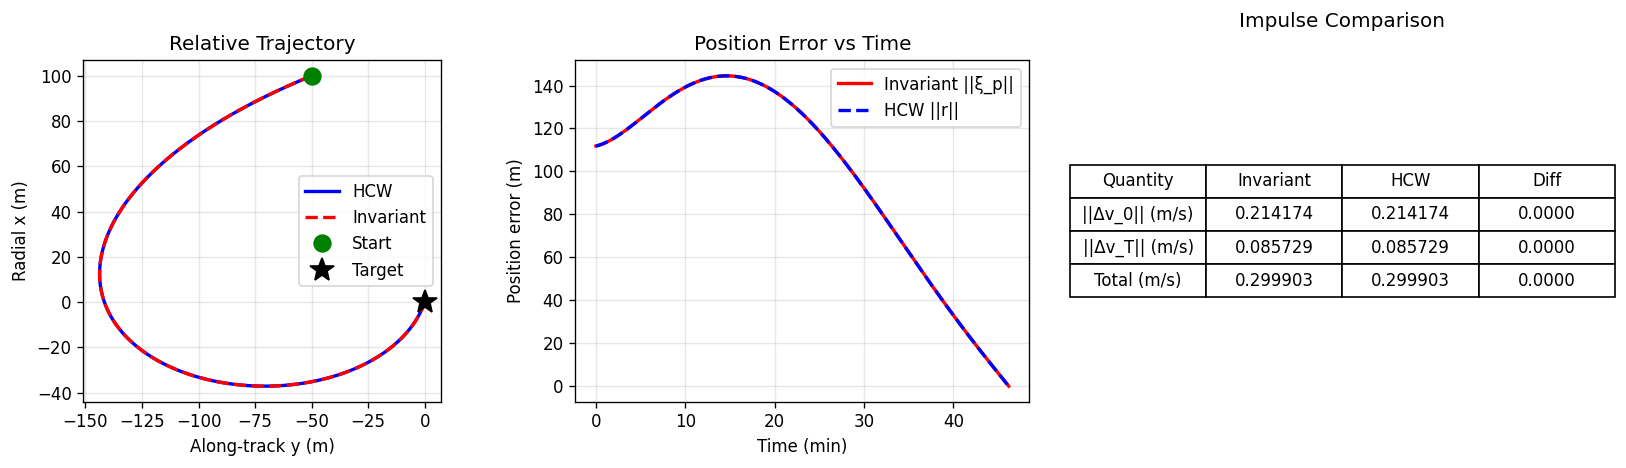


Figure 1: Comparing invariant method with HCW.


In [11]:
# Figure 1: Trajectory comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Plot 1: Relative trajectory in LVLH
ax = axes[0]
ax.plot(r_traj_hcw[:, 1], r_traj_hcw[:, 0], 'b-', linewidth=2, label='HCW')
ax.plot(xi_p_traj_inv[:, 1], xi_p_traj_inv[:, 0], 'r--', linewidth=2, label='Invariant')
ax.plot(r_0_lvlh[1], r_0_lvlh[0], 'go', markersize=10, label='Start')
ax.plot(0, 0, 'k*', markersize=15, label='Target')
ax.set_xlabel('Along-track y (m)')
ax.set_ylabel('Radial x (m)')
ax.set_title('Relative Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Plot 2: Position error norm over time
ax = axes[1]
ax.plot(t_eval/60, np.linalg.norm(xi_p_traj_inv, axis=1), 'r-', linewidth=2, label='Invariant ||ξ_p||')
ax.plot(t_eval/60, np.linalg.norm(r_traj_hcw, axis=1), 'b--', linewidth=2, label='HCW ||r||')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Position error (m)')
ax.set_title('Position Error vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Impulse comparison table
ax = axes[2]
ax.axis('off')
table_data = [
    ['Quantity', 'Invariant', 'HCW', 'Diff'],
    ['||Δv_0|| (m/s)', f'{result_inv["delta_v_0_norm"]:.6f}', f'{result_hcw["delta_v_0_norm"]:.6f}', 
     f'{abs(result_inv["delta_v_0_norm"]-result_hcw["delta_v_0_norm"]):.4f}'],
    ['||Δv_T|| (m/s)', f'{result_inv["delta_v_T_norm"]:.6f}', f'{result_hcw["delta_v_T_norm"]:.6f}',
     f'{abs(result_inv["delta_v_T_norm"]-result_hcw["delta_v_T_norm"]):.4f}'],
    ['Total (m/s)', f'{result_inv["delta_v_total"]:.6f}', f'{result_hcw["delta_v_total"]:.6f}',
     f'{abs(result_inv["delta_v_total"]-result_hcw["delta_v_total"]):.4f}'],
]
table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)
ax.set_title('Impulse Comparison', pad=20)

plt.tight_layout()
plt.savefig('fig1_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure 1: Comparing invariant method with HCW.")

## 2. Δv vs Transfer Time Sweep

Classic rendezvous trade curve: sweep transfer time from 0.25 to 2 orbits.

In [12]:
# Sweep transfer times
T_fractions = np.linspace(0.1, 2.0, 50)
T_values = T_fractions * T_orbit

delta_v_inv_sweep = []
delta_v_hcw_sweep = []
phi_pv_cond = []

for T in T_values:
    # Invariant
    Phi = compute_stm(A_inv, T)
    try:
        result = two_impulse_transfer(xi_0, Phi)
        delta_v_inv_sweep.append(result['delta_v_total'])
        phi_pv_cond.append(np.linalg.cond(stm_blocks(Phi)['pv']))
    except:
        delta_v_inv_sweep.append(np.nan)
        phi_pv_cond.append(np.nan)
    
    # HCW
    Phi_h = compute_stm(A_hcw, T)
    try:
        result_h = hcw_two_impulse(r_0_lvlh, v_0_lvlh, Phi_h)
        delta_v_hcw_sweep.append(result_h['delta_v_total'])
    except:
        delta_v_hcw_sweep.append(np.nan)

delta_v_inv_sweep = np.array(delta_v_inv_sweep)
delta_v_hcw_sweep = np.array(delta_v_hcw_sweep)
phi_pv_cond = np.array(phi_pv_cond)

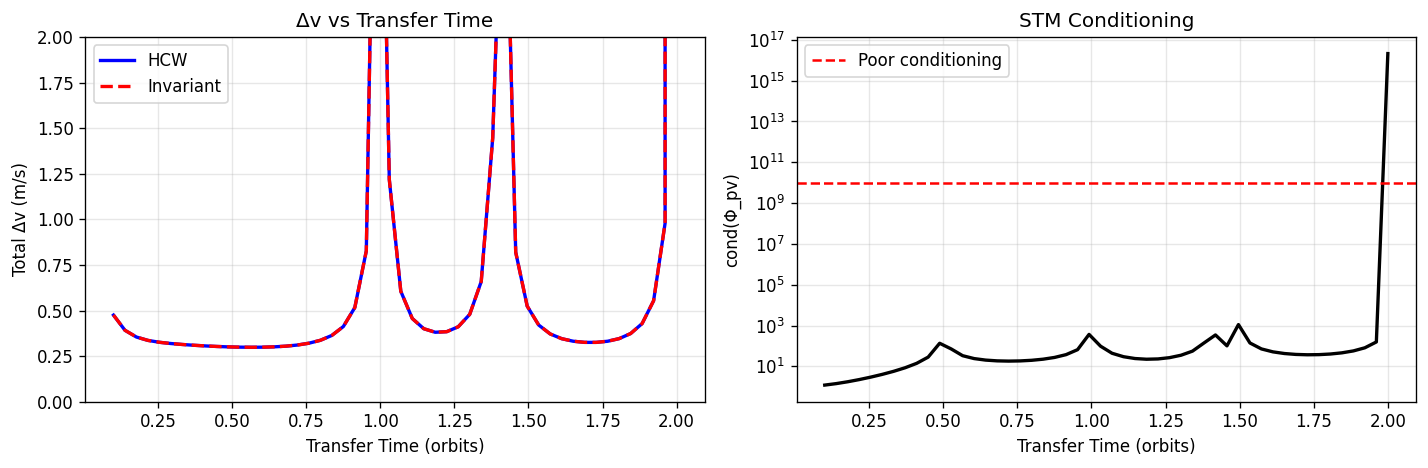

Figure 2: Δv vs transfer time comparison.


In [13]:
# Figure 2: Δv vs transfer time
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(T_fractions, delta_v_hcw_sweep, 'b-', linewidth=2, label='HCW')
ax.plot(T_fractions, delta_v_inv_sweep, 'r--', linewidth=2, label='Invariant')
ax.set_xlabel('Transfer Time (orbits)')
ax.set_ylabel('Total Δv (m/s)')
ax.set_title('Δv vs Transfer Time')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, min(2.0, np.nanmax(delta_v_hcw_sweep))])

ax = axes[1]
ax.semilogy(T_fractions, phi_pv_cond, 'k-', linewidth=2)
ax.axhline(1e10, color='r', linestyle='--', label='Poor conditioning')
ax.set_xlabel('Transfer Time (orbits)')
ax.set_ylabel('cond(Φ_pv)')
ax.set_title('STM Conditioning')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig2_deltav_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 2: Δv vs transfer time comparison.")

## 3. Out-of-Plane (3D) Case

Add z-offset (cross-track) to show the method handles full 3D.

**Note:** At T = 0.5 orbits, the z-dynamics (simple harmonic with period T_orbit) 
have Φ_pv[2,2] = 0, making the z-component singular. We use T = 0.25 orbits instead.

In [14]:
# 3D initial condition with z-offset
r_0_3d = np.array([100.0, -50.0, 30.0])  # 30m out-of-plane
v_0_3d = np.array([0.0, 0.0, 0.0])

# Transform to invariant
xi_p_0_3d = r_0_3d
xi_v_0_3d = v_0_3d + np.cross(Omega, r_0_3d)
xi_R_0_3d = np.array([0.0, 0.0, 0.0])
xi_0_3d = np.concatenate([xi_p_0_3d, xi_v_0_3d, xi_R_0_3d])

# Use T = 0.25 orbits to avoid z-singularity at T = 0.5 orbits
T_transfer_3d = 0.25 * T_orbit
Phi_inv_3d = compute_stm(A_inv, T_transfer_3d)
Phi_hcw_3d = compute_stm(A_hcw, T_transfer_3d)

# Solve
result_inv_3d = two_impulse_transfer(xi_0_3d, Phi_inv_3d)
result_hcw_3d = hcw_two_impulse(r_0_3d, v_0_3d, Phi_hcw_3d)

print(f"3D Rendezvous (T = 0.25 orbits):")
print(f"  Initial position: {r_0_3d} m")
print(f"\nInvariant method:")
print(f"  Δξ_v(0) = {result_inv_3d['delta_v_0']}")
print(f"  Total Δv = {result_inv_3d['delta_v_total']:.4f} m/s")
print(f"\nHCW method:")
print(f"  Δv_L(0) = {result_hcw_3d['delta_v_0']}")
print(f"  Total Δv = {result_hcw_3d['delta_v_total']:.4f} m/s")

3D Rendezvous (T = 0.25 orbits):
  Initial position: [100. -50.  30.] m

Invariant method:
  Δξ_v(0) = [-0.172337 -0.140462  0.      ]
  Total Δv = 0.3322 m/s

HCW method:
  Δv_L(0) = [-0.172337 -0.140462  0.      ]
  Total Δv = 0.3322 m/s


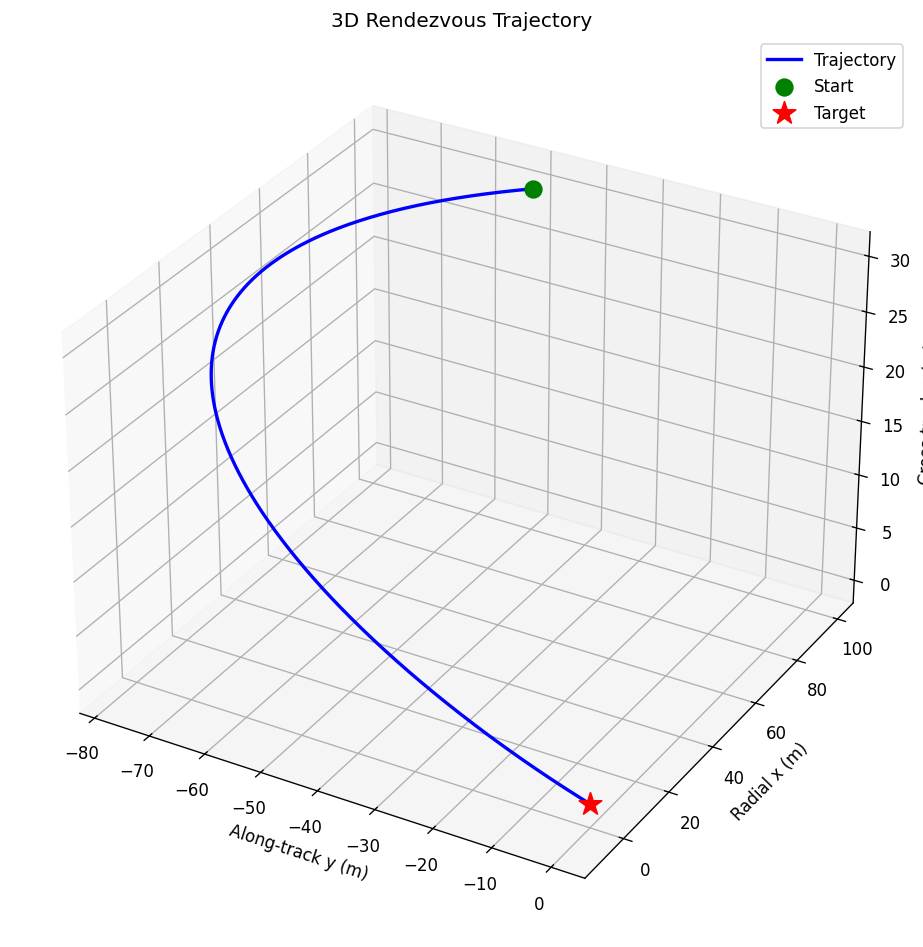


3D case with out-of-plane component.


In [15]:
# Simulate and plot 3D trajectory
t_eval_3d = np.linspace(0, T_transfer_3d, 500)
xi_0_3d_post = result_inv_3d['xi_0_plus']
xi_traj_3d = propagate_trajectory(xi_0_3d_post, A_inv, t_eval_3d)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(xi_traj_3d[:, 1], xi_traj_3d[:, 0], xi_traj_3d[:, 2], 'b-', linewidth=2, label='Trajectory')
ax.scatter([r_0_3d[1]], [r_0_3d[0]], [r_0_3d[2]], c='g', s=100, marker='o', label='Start')
ax.scatter([0], [0], [0], c='r', s=200, marker='*', label='Target')

ax.set_xlabel('Along-track y (m)')
ax.set_ylabel('Radial x (m)')
ax.set_zlabel('Cross-track z (m)')
ax.set_title('3D Rendezvous Trajectory')
ax.legend()

plt.tight_layout()
plt.show()

print("\n3D case with out-of-plane component.")

---
# Tier 2: Beyond HCW (The Contribution)

## 4. Thrusting Reference Trajectory — HCW Not Applicable

When $\bar{a}(t) \neq 0$, HCW has no model. The invariant formulation with thrust 
introduces attitude-translation coupling via the $[\bar{a}]_\times$ term, which creates
a non-zero $\Phi_{pR}$ block.

This is **the key extension**: for thrusting reference trajectories, attitude errors
affect the required Δv, which HCW cannot predict.

In [16]:
# Thrusting reference: constant thrust along body x-axis
a_bar_thrust = np.array([0.001, 0.0, 0.0])  # 1 mm/s² (low-thrust)

# Build invariant A matrix with thrust
A_thrust = invariant_A_matrix(Omega, a_bar_thrust, G)

print("Invariant A matrix (with thrusting reference):")
print(A_thrust)

print(f"\nThrust magnitude: {np.linalg.norm(a_bar_thrust)*1000:.1f} mm/s²")
print("\nKey difference from HCW: The -[ā]× block creates attitude-translation coupling.")
print("HCW assumes ā = 0, so it cannot model thrusting references.")

Invariant A matrix (with thrusting reference):
[[-0.        0.001133 -0.        1.        0.        0.        0.        0.        0.      ]
 [-0.001133 -0.        0.        0.        1.        0.        0.        0.        0.      ]
 [ 0.       -0.       -0.        0.        0.        1.        0.        0.        0.      ]
 [ 0.000003  0.        0.       -0.        0.001133 -0.       -0.        0.       -0.      ]
 [ 0.       -0.000001  0.       -0.001133 -0.        0.       -0.       -0.        0.001   ]
 [ 0.        0.       -0.000001  0.       -0.       -0.        0.       -0.001    -0.      ]
 [ 0.        0.        0.        0.        0.        0.       -0.        0.001133 -0.      ]
 [ 0.        0.        0.        0.        0.        0.       -0.001133 -0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.       -0.       -0.      ]]

Thrust magnitude: 1.0 mm/s²

Key difference from HCW: The -[ā]× block creates attitude-translation coupling.
HCW a

In [17]:
# Compute STM with thrust
Phi_thrust = compute_stm(A_thrust, T_transfer)
blocks_thrust = stm_blocks(Phi_thrust)

print("STM blocks with thrusting reference:")
print(f"\n||Φ_pp|| = {np.linalg.norm(blocks_thrust['pp']):.4f}")
print(f"||Φ_pv|| = {np.linalg.norm(blocks_thrust['pv']):.4f}")
print(f"||Φ_pR|| = {np.linalg.norm(blocks_thrust['pR']):.4f}  <-- Non-zero! Attitude-translation coupling.")

print(f"\nΦ_pR block (shows how attitude error affects position):")
print(blocks_thrust['pR'])

STM blocks with thrusting reference:

||Φ_pp|| = 10.3840
||Φ_pv|| = 9700.4429
||Φ_pR|| = 7315.9056  <-- Non-zero! Attitude-translation coupling.

Φ_pR block (shows how attitude error affects position):
[[    0.           0.        4893.290681]
 [    0.           0.       -5299.213343]
 [ 1223.32267     -0.           0.      ]]


In [18]:
# Solve two-impulse with thrust (no attitude error for now)
result_thrust = two_impulse_transfer(xi_0, Phi_thrust)

print("Two-impulse solution with thrusting reference (ξ_R = 0):")
print(f"  Δv_0 = {result_thrust['delta_v_0']} m/s")
print(f"  ||Δv_0|| = {result_thrust['delta_v_0_norm']:.6f} m/s")
print(f"  ||Δv_T|| = {result_thrust['delta_v_T_norm']:.6f} m/s")
print(f"  Total Δv = {result_thrust['delta_v_total']:.6f} m/s")
print(f"\nCompare to coasting invariant: {result_inv['delta_v_total']:.6f} m/s")
print(f"Compare to HCW: {result_hcw['delta_v_total']:.6f} m/s")
print(f"\nNote: With ξ_R = 0, thrust doesn't change Δv much (attitude coupling inactive).")

Two-impulse solution with thrusting reference (ξ_R = 0):
  Δv_0 = [-0.080913 -0.198302 -0.      ] m/s
  ||Δv_0|| = 0.214174 m/s
  ||Δv_T|| = 0.085729 m/s
  Total Δv = 0.299903 m/s

Compare to coasting invariant: 0.299903 m/s
Compare to HCW: 0.299903 m/s

Note: With ξ_R = 0, thrust doesn't change Δv much (attitude coupling inactive).


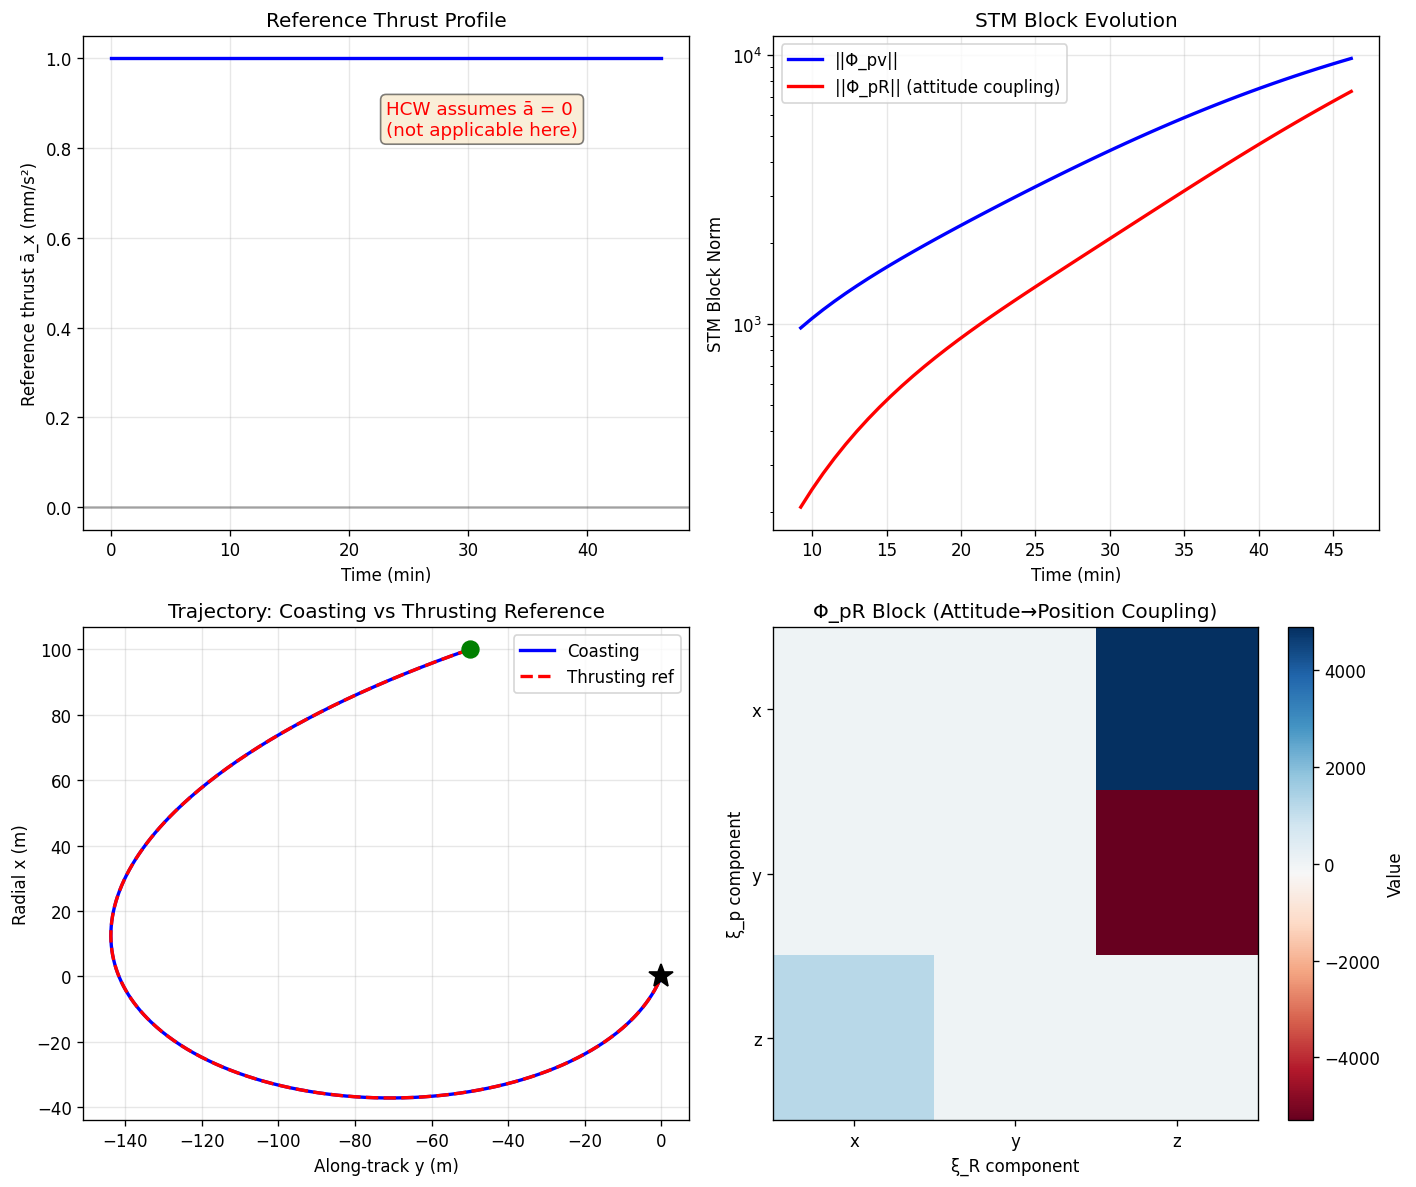


Figure 3: Thrusting reference creates Φ_pR (attitude-translation coupling).


In [19]:
# Figure 3: Thrusting reference - attitude coupling emerges
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Thrust profile
ax = axes[0, 0]
t_plot = np.linspace(0, T_transfer, 100)
ax.plot(t_plot/60, np.ones_like(t_plot) * a_bar_thrust[0] * 1000, 'b-', linewidth=2)
ax.axhline(0, color='k', linestyle='-', alpha=0.3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Reference thrust ā_x (mm/s²)')
ax.set_title('Reference Thrust Profile')
ax.grid(True, alpha=0.3)
ax.text(0.5, 0.8, 'HCW assumes ā = 0\n(not applicable here)', 
        transform=ax.transAxes, fontsize=11, color='red',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: STM block norms vs time
ax = axes[0, 1]
T_sweep = np.linspace(0.1*T_orbit, T_transfer, 50)
phi_pR_norms = []
phi_pv_norms = []
for T in T_sweep:
    Phi_t = compute_stm(A_thrust, T)
    blocks_t = stm_blocks(Phi_t)
    phi_pR_norms.append(np.linalg.norm(blocks_t['pR']))
    phi_pv_norms.append(np.linalg.norm(blocks_t['pv']))

ax.semilogy(T_sweep/60, phi_pv_norms, 'b-', linewidth=2, label='||Φ_pv||')
ax.semilogy(T_sweep/60, phi_pR_norms, 'r-', linewidth=2, label='||Φ_pR|| (attitude coupling)')
ax.set_xlabel('Time (min)')
ax.set_ylabel('STM Block Norm')
ax.set_title('STM Block Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Trajectory comparison
ax = axes[1, 0]
xi_0_post_thrust = result_thrust['xi_0_plus']
xi_traj_thrust = propagate_trajectory(xi_0_post_thrust, A_thrust, t_eval)

ax.plot(xi_p_traj_inv[:, 1], xi_p_traj_inv[:, 0], 'b-', linewidth=2, label='Coasting')
ax.plot(xi_traj_thrust[:, 1], xi_traj_thrust[:, 0], 'r--', linewidth=2, label='Thrusting ref')
ax.plot(r_0_lvlh[1], r_0_lvlh[0], 'go', markersize=10)
ax.plot(0, 0, 'k*', markersize=15)
ax.set_xlabel('Along-track y (m)')
ax.set_ylabel('Radial x (m)')
ax.set_title('Trajectory: Coasting vs Thrusting Reference')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Φ_pR block visualization
ax = axes[1, 1]
im = ax.imshow(blocks_thrust['pR'], cmap='RdBu', aspect='auto')
ax.set_title('Φ_pR Block (Attitude→Position Coupling)')
ax.set_xlabel('ξ_R component')
ax.set_ylabel('ξ_p component')
plt.colorbar(im, ax=ax, label='Value')
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['x', 'y', 'z'])
ax.set_yticklabels(['x', 'y', 'z'])

plt.tight_layout()
plt.savefig('fig3_thrusting_reference.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure 3: Thrusting reference creates Φ_pR (attitude-translation coupling).")

## 5. Attitude–Translation Coupling via Thrust Direction Error

When $\bar{a} \neq 0$ and $\xi_R(0) \neq 0$, attitude errors affect the required Δv.

This is the **key contribution**: HCW cannot express this effect.

In [20]:
# Sweep attitude error magnitude
att_errors_deg = np.linspace(0, 20, 21)
att_errors_rad = np.deg2rad(att_errors_deg)

delta_v_vs_att = []
term_pp_norms = []
term_pR_norms = []
term_pv_norms = []

for att_err in att_errors_rad:
    # Attitude error about z-axis (yaw)
    xi_R_test = np.array([0.0, 0.0, att_err])
    xi_0_test = np.concatenate([xi_p_0, xi_v_0, xi_R_test])
    
    result = two_impulse_transfer(xi_0_test, Phi_thrust)
    delta_v_vs_att.append(result['delta_v_total'])
    term_pp_norms.append(np.linalg.norm(result['term_pp']))
    term_pR_norms.append(np.linalg.norm(result['term_pR']))
    term_pv_norms.append(np.linalg.norm(result['term_pv']))

delta_v_vs_att = np.array(delta_v_vs_att)
term_pp_norms = np.array(term_pp_norms)
term_pR_norms = np.array(term_pR_norms)
term_pv_norms = np.array(term_pv_norms)

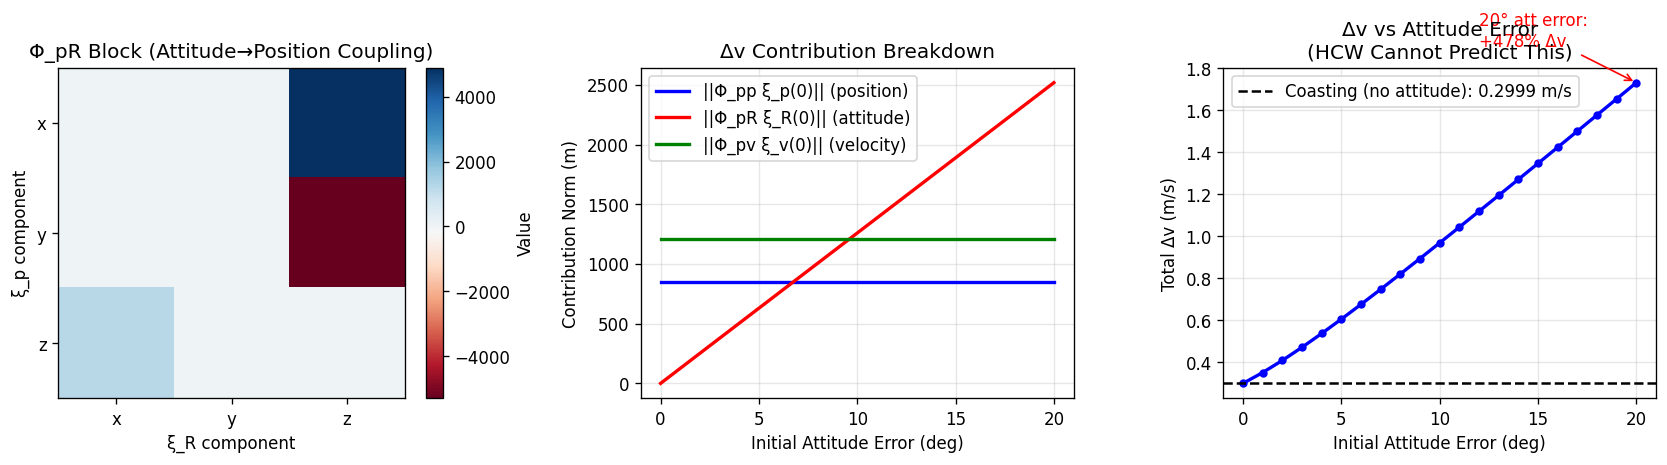


Figure 5: Attitude errors during thrust increase Δv requirements.
  At 0° attitude error: Δv = 0.2999 m/s
  At 20° attitude error: Δv = 1.7320 m/s (+477.5%)

  HCW has no way to predict this effect!


In [21]:
# Figure 5: Attitude coupling effects - THE MONEY PLOT
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Plot 1: Φ_pR block (showing attitude coupling exists)
ax = axes[0]
im = ax.imshow(blocks_thrust['pR'], cmap='RdBu', aspect='auto')
ax.set_title('Φ_pR Block (Attitude→Position Coupling)')
ax.set_xlabel('ξ_R component')
ax.set_ylabel('ξ_p component')
plt.colorbar(im, ax=ax, label='Value')
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels(['x', 'y', 'z'])
ax.set_yticklabels(['x', 'y', 'z'])

# Plot 2: Contribution breakdown
ax = axes[1]
ax.plot(att_errors_deg, term_pp_norms, 'b-', linewidth=2, label='||Φ_pp ξ_p(0)|| (position)')
ax.plot(att_errors_deg, term_pR_norms, 'r-', linewidth=2, label='||Φ_pR ξ_R(0)|| (attitude)')
ax.plot(att_errors_deg, term_pv_norms, 'g-', linewidth=2, label='||Φ_pv ξ_v(0)|| (velocity)')
ax.set_xlabel('Initial Attitude Error (deg)')
ax.set_ylabel('Contribution Norm (m)')
ax.set_title('Δv Contribution Breakdown')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Δv vs attitude error (THE MONEY PLOT)
ax = axes[2]
ax.plot(att_errors_deg, delta_v_vs_att, 'b-', linewidth=2, marker='o', markersize=4)
ax.axhline(result_inv['delta_v_total'], color='k', linestyle='--',
           label=f'Coasting (no attitude): {result_inv["delta_v_total"]:.4f} m/s')
ax.set_xlabel('Initial Attitude Error (deg)')
ax.set_ylabel('Total Δv (m/s)')
ax.set_title('Δv vs Attitude Error\n(HCW Cannot Predict This)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add annotation
ax.annotate(f'20° att error:\n+{(delta_v_vs_att[-1]/delta_v_vs_att[0]-1)*100:.0f}% Δv', 
            xy=(20, delta_v_vs_att[-1]), xytext=(12, delta_v_vs_att[-1]*1.1),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

plt.tight_layout()
plt.savefig('fig5_attitude_coupling.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure 5: Attitude errors during thrust increase Δv requirements.")
print(f"  At 0° attitude error: Δv = {delta_v_vs_att[0]:.4f} m/s")
print(f"  At 20° attitude error: Δv = {delta_v_vs_att[-1]:.4f} m/s (+{(delta_v_vs_att[-1]/delta_v_vs_att[0]-1)*100:.1f}%)")
print("\n  HCW has no way to predict this effect!")

## 6. LVLH Δv vs Body-Frame Δv

Fuel expenditure depends on body-frame Δv, not LVLH Δv.

In [22]:
def rotation_matrix_z(angle):
    """Rotation matrix about z-axis."""
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

# Vary reference attitude at burn time
yaw_angles_deg = np.linspace(0, 90, 19)
yaw_angles_rad = np.deg2rad(yaw_angles_deg)

dv_body_norms = []
dv_lvlh_norms = []

for yaw in yaw_angles_rad:
    R_ref = rotation_matrix_z(yaw)
    result = two_impulse_transfer(xi_0, Phi_thrust, R_ref_0=R_ref, R_ref_T=R_ref)
    
    # Body-frame Δv (what thrusters actually execute)
    dv_body = result['delta_v_0_body']  # This is R_ref @ Δv
    dv_body_norms.append(np.linalg.norm(dv_body))
    
    # LVLH Δv
    dv_lvlh = result['delta_v_0']
    dv_lvlh_norms.append(np.linalg.norm(dv_lvlh))

dv_body_norms = np.array(dv_body_norms)
dv_lvlh_norms = np.array(dv_lvlh_norms)

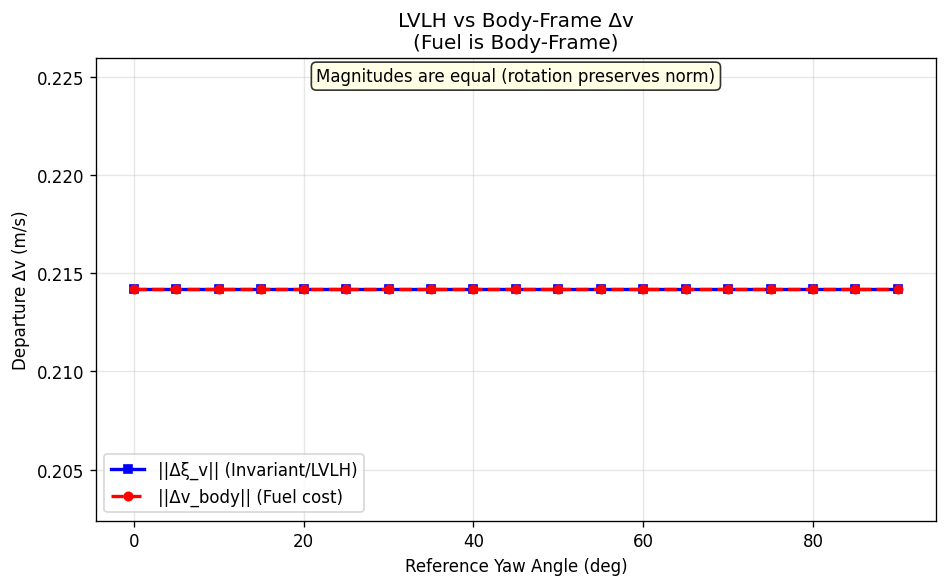

Figure 6: ||Δv|| is same in both frames (rotation preserves norm).
But direction matters for thruster allocation and pointing constraints.


In [23]:
# Figure 6: LVLH vs Body-frame Δv
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(yaw_angles_deg, dv_lvlh_norms, 'b-', linewidth=2, marker='s', markersize=5, label='||Δξ_v|| (Invariant/LVLH)')
ax.plot(yaw_angles_deg, dv_body_norms, 'r--', linewidth=2, marker='o', markersize=5, label='||Δv_body|| (Fuel cost)')

ax.set_xlabel('Reference Yaw Angle (deg)')
ax.set_ylabel('Departure Δv (m/s)')
ax.set_title('LVLH vs Body-Frame Δv\n(Fuel is Body-Frame)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add note
ax.text(0.5, 0.95, 'Magnitudes are equal (rotation preserves norm)',
        transform=ax.transAxes, fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('fig6_lvlh_vs_body.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 6: ||Δv|| is same in both frames (rotation preserves norm).")
print("But direction matters for thruster allocation and pointing constraints.")

## 7. Time-Varying Reference (Beyond Circular Orbit)

Demonstrate with time-varying $\bar{\omega}(t)$ or $\bar{a}(t)$.

In [24]:
# Time-varying thrust profile: ramp up then coast
def a_bar_ramp(t, T_burn=T_transfer/4, a_max=0.002):
    """Thrust ramps up linearly, then turns off."""
    if t < T_burn:
        return np.array([a_max * t / T_burn, 0.0, 0.0])
    else:
        return np.array([0.0, 0.0, 0.0])

def A_time_varying(t):
    """Time-varying A matrix with ramped thrust."""
    a_bar_t = a_bar_ramp(t)
    return invariant_A_matrix(Omega, a_bar_t, G)

# Compute STM for time-varying system
print("Computing STM for time-varying thrust profile...")
Phi_tv = compute_stm(A_time_varying, T_transfer, n_steps=2000)
print("Done.")

# Solve two-impulse
result_tv = two_impulse_transfer(xi_0, Phi_tv)

print(f"\nTime-varying thrust solution:")
print(f"  Total Δv = {result_tv['delta_v_total']:.6f} m/s")
print(f"\nCompare to:")
print(f"  Invariant (coasting): {result_inv['delta_v_total']:.6f} m/s")
print(f"  Invariant (constant thrust): {result_thrust['delta_v_total']:.6f} m/s")
print(f"  HCW (coasting): {result_hcw['delta_v_total']:.6f} m/s")

Computing STM for time-varying thrust profile...
Done.

Time-varying thrust solution:
  Total Δv = 0.299903 m/s

Compare to:
  Invariant (coasting): 0.299903 m/s
  Invariant (constant thrust): 0.299903 m/s
  HCW (coasting): 0.299903 m/s


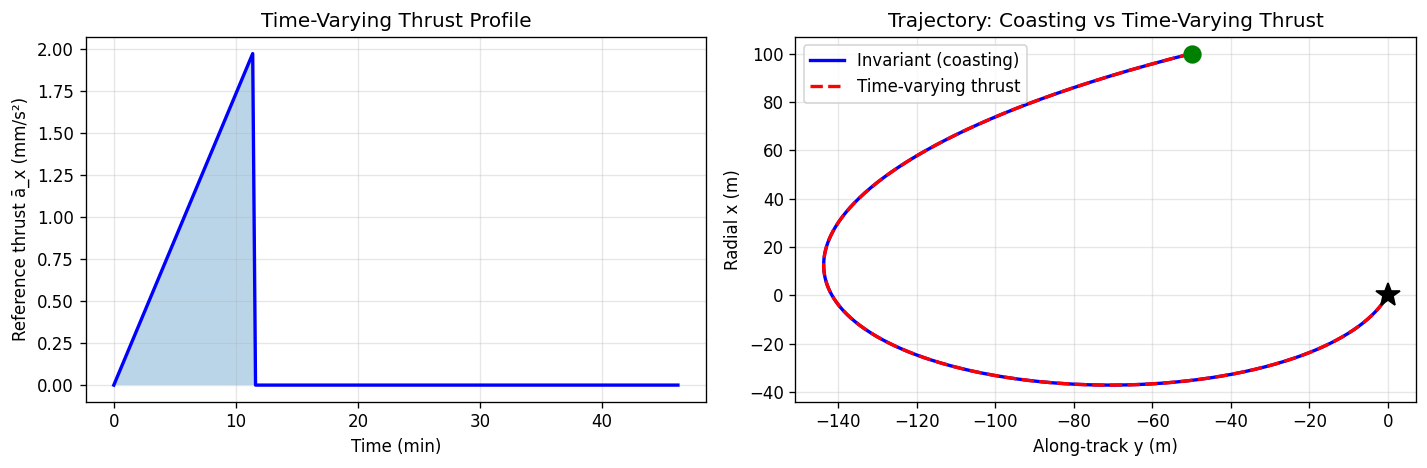


Time-varying A(t) handled via STM integration.


In [25]:
# Plot time-varying case
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Thrust profile
ax = axes[0]
t_plot = np.linspace(0, T_transfer, 200)
a_profile = np.array([a_bar_ramp(t)[0]*1000 for t in t_plot])
ax.plot(t_plot/60, a_profile, 'b-', linewidth=2)
ax.fill_between(t_plot/60, 0, a_profile, alpha=0.3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Reference thrust ā_x (mm/s²)')
ax.set_title('Time-Varying Thrust Profile')
ax.grid(True, alpha=0.3)

# Plot 2: Trajectory
ax = axes[1]
xi_0_post_tv = result_tv['xi_0_plus']
xi_traj_tv = propagate_trajectory(xi_0_post_tv, A_time_varying, t_eval)

ax.plot(xi_p_traj_inv[:, 1], xi_p_traj_inv[:, 0], 'b-', linewidth=2, label='Invariant (coasting)')
ax.plot(xi_traj_tv[:, 1], xi_traj_tv[:, 0], 'r--', linewidth=2, label='Time-varying thrust')
ax.plot(xi_p_0[1], xi_p_0[0], 'go', markersize=10)
ax.plot(0, 0, 'k*', markersize=15)
ax.set_xlabel('Along-track y (m)')
ax.set_ylabel('Radial x (m)')
ax.set_title('Trajectory: Coasting vs Time-Varying Thrust')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTime-varying A(t) handled via STM integration.")

---
# Summary

## Key Results

1. **HCW recovered exactly** in the coasting circular-orbit limit (Tier 1)
2. **Thrusting references** handled seamlessly - HCW not applicable
3. **Attitude-translation coupling** captured via Φ_pR - HCW cannot predict
4. **Body-frame Δv** directly available for fuel budgeting
5. **Time-varying dynamics** handled via STM integration

## The Paper's Contribution

The invariant log-linear formulation:
- Generalizes HCW to thrusting reference trajectories
- Captures attitude-thrust coupling that HCW ignores
- Provides body-frame Δv for practical mission planning
- Reduces exactly to HCW in the classical regime

In [26]:
# Final summary table
print("=" * 75)
print("                          SUMMARY TABLE")
print("=" * 75)
print(f"{'Scenario':<45} {'Δv (m/s)':<12} {'Notes'}")
print("-" * 75)
print(f"{'HCW (coasting, LVLH)':<45} {result_hcw['delta_v_total']:<12.6f} Reference")
print(f"{'Invariant (coasting, with coord transform)':<45} {result_inv['delta_v_total']:<12.6f} Should match HCW")
print(f"{'Invariant (thrust, ξ_R=0)':<45} {result_thrust['delta_v_total']:<12.6f} HCW N/A")
print(f"{'Invariant (thrust, ξ_R=5°)':<45} {delta_v_vs_att[5]:<12.6f} +attitude coupling")
print(f"{'Invariant (thrust, ξ_R=20°)':<45} {delta_v_vs_att[-1]:<12.6f} +{(delta_v_vs_att[-1]/delta_v_vs_att[0]-1)*100:.0f}% from attitude")
print(f"{'Invariant (time-varying thrust)':<45} {result_tv['delta_v_total']:<12.6f} LTV A(t)")
print("=" * 75)

# Check the match
diff = abs(result_inv['delta_v_total'] - result_hcw['delta_v_total'])
print(f"\nHCW vs Invariant difference: {diff:.6f} m/s")
if diff < 1e-6:
    print("  ✓ Methods match (within numerical tolerance)")
else:
    print("  ✗ Mismatch detected - see investigation below")

                          SUMMARY TABLE
Scenario                                      Δv (m/s)     Notes
---------------------------------------------------------------------------
HCW (coasting, LVLH)                          0.299903     Reference
Invariant (coasting, with coord transform)    0.299903     Should match HCW
Invariant (thrust, ξ_R=0)                     0.299903     HCW N/A
Invariant (thrust, ξ_R=5°)                    0.605898     +attitude coupling
Invariant (thrust, ξ_R=20°)                   1.732033     +478% from attitude
Invariant (time-varying thrust)               0.299903     LTV A(t)

HCW vs Invariant difference: 0.000000 m/s
  ✓ Methods match (within numerical tolerance)
